# Laborarbeit Künstliche Intelligenz

## Thema :  Evolutionary Computing & Constraint Satisfaction Problems

### Namen der Studierenden: Michael Dehm & Tim Teller

(Hinweis: Es sind Namen anzugeben und keine Matrikelnummern. Matrikelnummern werden ausschließlich bei Klausuren zur Anonymisierung verwendet)

# Installs

In [ ]:
%pip install seaborn matplotlib pandas deap python-constraint ortools

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
from collections import Counter
import random
from copy import deepcopy

# Einlesen der Konfigurations-Datei für Ihre Aufgabe
def load_configuration():
    with open('configuration_003.json', 'r') as file:
        return json.load(file)

configuration = load_configuration()

#### Die Konfiguration betrachten

In [ ]:
def print_configuration(configuration):
    
    print("\nAusführliche Konfiguration:\n")
    
    print("Studiengänge und Kursgruppenanzahlen:")
    for program, groups in configuration['study_programs'].items():
        print(f"- {program}: {groups} Kursgruppen")
    
    print("\nPrüfungswochen und zugeordnete Studiengänge:")
    for week, programs in configuration['exam_weeks'].items():
        print(f"- {week}: {', '.join(programs)}")
    
    print("\nZeitslots mit Beliebtheit:")
    for slot, details in configuration['time_slots'].items():
        print(f"- {slot} ({details['time']}): Beliebtheit {details['popularity']}")
    
    print("\nTage der Woche mit Beliebtheit:")
    for day, details in configuration['days'].items():
        print(f"- {day}: Beliebtheit {details['popularity']}")
    
    print("\nBeliebtheit von Raumzuteilungen:")
    print(f"- Parallel zugeteilte Räume: Beliebtheit {configuration['room_popularity']['parallel']}")
    print(f"- Zeitlich hintereinander zugeteilte Räume: Beliebtheit {configuration['room_popularity']['sequential']}")


In [ ]:
print_configuration(configuration)

Die hier angegebenen Beliebtheitswerte fließen in die Bewertungsfunktion ein, die von Ihnen noch anzupassen ist.

In [ ]:
# Nur als Beispiel und zur Veranschaulichung ... zufällige Zuteilung generieren
import random


def random_assign_timeslots(week_number, configuration):
    study_programs = configuration['exam_weeks'].get(f"Week {week_number}", [])
    
    # Struktur für die Zuteilung: Dict of days containing list of slots each with two rooms
    schedule = {day: {slot: [None, None] for slot in configuration['time_slots']} for day in configuration['days']}
    
    # Erstelle eine Liste aller Zeit-Slot Kombinationen für eine Woche
    time_slot_combinations = [(day, slot) for day in schedule for slot in schedule[day]]
    
    # Verteile die Studiengänge zufällig, bis alle Slots gefüllt sind
    for (day, slot) in time_slot_combinations:
        for i in range(2):  # Zwei Räume pro Slot
            program = random.choice(study_programs)
            schedule[day][slot][i] = program
    
    return schedule

def print_schedule(schedule):
    days = list(schedule.keys())
    slots = list(schedule[days[0]].keys())
    
    # Erste Zeile: Tage der Woche
    day_line = "Zeit / Tage  " + "".join([f"{day:^20}" for day in days])
    
    # Zweite Zeile: Räume unter jedem Tag anzeigen
    room_line = " " * 12 + "".join([f"{'R1':^10}{'R2':^10}" for _ in days])
    
    line_length = len(day_line)
    line = "-" * line_length
    
    print(line)
    print(day_line)
    print(room_line)
    print(line)

    for slot in slots:
        print(f"{slot:^10} ", end="")
        for day in days:
            rooms = schedule[day][slot]
            r1, r2 = rooms[0], rooms[1]
            print(f"{r1:^10}{r2:^10}", end="")
        print()
    print(line)



In [ ]:
# Beispiel für Verwendung

week_number = 2  # Zum Beispiel die erste Prüfungswoche
schedule = random_assign_timeslots(week_number, configuration)
print(schedule)
print_schedule(schedule)

## Aufgabenteil 1: Evolutionary Computing

Entwerfen Sie ein KI Modell auf Basis des Evolutionary Computing und setzen
Sie dieses als Jupyter Notebook um. Insbesondere werden eine geeignete Repräsentation
sowie eine geeignete Fitness-Funktion benötigt.

### 1. Modell anlegen

- Individuenformat festlegen
- Fitnessfunktion festlegen
- Mutation und Crossover geeignet wählen

#### Erläuterung / Begründung zur Modellierung von Individuen
Die Prüfungspläne der einzelnen Wochen wurden als Individuen definiert und jeweils in wöchentliche Populationen dem evolutionären Optimierungsalgorithmus unterzogen.
Da das Evolutionary Computing nativ und ohne Framework implementiert wurde, war keine separate Modellierung eines Individuums erforderlich sondern die vorgegebene Struktur konnte direkt verwendet werden.

### Fittnesfunktion, Crossoverfunktion und Mutationsfunktion

In [ ]:
# Berechnet die Varianz über die Werte der Studiengänge zur Bestimmung der Unfairness
def calc_unfairness(scores_by_study_program):
    vals = list(scores_by_study_program.values())
    var = np.var(vals)
    return var

# Bewertungsfunktion (Fitness) eines gegebenen Prüfungsplans
def calc_fittnes(
        schedule,
        week_number,
        configuration,
        parallel_popularity_score_factor=1,
        consecutive_popularity_score_factor=1,
        day_popularity_score_factor=1,
        slot_popularity_score_factor=1,
        unfairness_parallel_popularity_score_factor=1,
        unfairness_consecutive_popularity_score_factor=1,
        unfairness_day_popularity_score_factor=1,
        unfairness_slot_popularity_score_factor=1,
        unproportional_slots_penalty_factor=10,
        unfairness_slot_not_every_day_factor=1,
        slot_not_every_day_penalty_factor=10,
        early_late_slots_penalty_factor=10
        ):

    # Berechnung der Gesamtanzahl verfügbarer Slots
    day_num = len(configuration['days'])
    room_num = 2
    slot_num = len(configuration['time_slots'])
    total_slots = day_num*room_num*slot_num

    # Relevante Studiengänge und deren Kursanzahl für die Woche
    programs_this_week = configuration['exam_weeks'][f'Week {week_number}']
    courses_per_program = configuration['study_programs']

    # Gesamtzahl der Kurse in dieser Woche
    total_courses = 0
    for study_program in programs_this_week:
        total_courses += courses_per_program[study_program]
    
    # Berechnung der proportional zuzuweisenden Slots pro Studiengang
    proportional_slots = {}
    for study_program in programs_this_week:
        proportional_slots[study_program] = courses_per_program[study_program]/total_courses * total_slots
    
    # Zählen der tatsächlichen Slotbelegungen
    all_values = []
    for day_slots in schedule.values():
        for slot in day_slots.values():
            all_values.extend(slot)
    count = Counter(all_values)
    actual_slots = dict(count)

    # Strafwert für unproportionale Slotverteilung
    unproportional_slots_penalty = 0
    for study_program in actual_slots:
        unproportional_slots_penalty += np.abs(actual_slots[study_program]-proportional_slots[study_program])
    

    # Initialisierung von Beliebtheitsscores für verschiedene Kriterien
    parallel_popularity_scores_by_study_program = {}
    consecutive_popularity_scores_by_study_program = {}
    day_popularity_scores_by_study_program = {}
    slot_popularity_scores_by_study_program = {}
    for study_program in programs_this_week:
        parallel_popularity_scores_by_study_program[study_program] = 0
        consecutive_popularity_scores_by_study_program[study_program] = 0
        day_popularity_scores_by_study_program[study_program] = 0
        slot_popularity_scores_by_study_program[study_program] = 0

    # Bewertung paralleler Prüfungen großer Studiengänge
    big_course_parallel_popularity = configuration['room_popularity']['parallel']
    for day in schedule:
        for slot in schedule[day]:
            parallel_rooms_by_study_program = Counter(schedule[day][slot])
            for study_program in dict(parallel_rooms_by_study_program):
                if courses_per_program[study_program] > 1 and parallel_rooms_by_study_program[study_program] > 1:
                    parallel_popularity_scores_by_study_program[study_program] += big_course_parallel_popularity

    # Bewertung aufeinanderfolgender Prüfungen
    course_consecutive_popularity = configuration['room_popularity']['sequential']
    for day in schedule:
        for i in range(1,len(schedule[day])):
            prev_key = list(schedule[day])[i-1]
            key = list(schedule[day])[i]
            prev_slot = schedule[day][prev_key]
            slot = schedule[day][key]
            for k in range(0,room_num):
                if(slot[k] in prev_slot):
                    consecutive_popularity_scores_by_study_program[slot[k]] += course_consecutive_popularity
    
    # Bewertung der Tages- und Slot-Beliebtheit
    for day in schedule:
        for slot in schedule[day]:
            for study_program in schedule[day][slot]:
                day_popularity = configuration['days'][day]['popularity']
                slot_popularity = configuration['time_slots'][slot]['popularity']
                day_popularity_scores_by_study_program[study_program] += day_popularity
                slot_popularity_scores_by_study_program[study_program] += slot_popularity
    
    # Normierung der Beliebtheitsscores
    for study_program in programs_this_week:
        parallel_popularity_scores_by_study_program[study_program] /= courses_per_program[study_program]
        consecutive_popularity_scores_by_study_program[study_program] /= courses_per_program[study_program]
        day_popularity_scores_by_study_program[study_program] /= courses_per_program[study_program]
        slot_popularity_scores_by_study_program[study_program] /= courses_per_program[study_program]

    # Ausschluss von Studiengängen mit nur einem Kurs aus Parallelwertungen
    for study_program in programs_this_week:
        if courses_per_program[study_program] <= 1:
            del parallel_popularity_scores_by_study_program[study_program]

    # Zählung der Prüfungstage pro Studiengang
    number_of_days_by_program = {}
    for program in programs_this_week:
        number_of_days_by_program[program] = 0
    for day in schedule:
        programs_this_day = []
        for slot in schedule[day]:
            for program in schedule[day][slot]:
                programs_this_day.append(program)
        for program in number_of_days_by_program:
            if program in programs_this_day:
                number_of_days_by_program[program] += 1
    
    # Strafwert für Studiengänge, die nicht an allen Tagen Prüfungen haben
    slot_not_every_day_penalty = day_num*len(programs_this_week)
    for program in number_of_days_by_program:
        slot_not_every_day_penalty -= number_of_days_by_program[program]


    # Strafwert für Prüfungen am Ende eines Tages und direkt zu Beginn des Folgetages
    early_late_slots_penalty = 0
    for i in range(1,len(schedule)):
        prev_day = list(schedule)[i-1]
        day = list(schedule)[i]
        last_slot_prey_day = list(schedule[prev_day].values())[-1]
        first_slot_this_day = list(schedule[day].values())[0]
        for program in last_slot_prey_day:
            if program in first_slot_this_day:
                early_late_slots_penalty += 1

    # Berechnung der Unfairness für jede Beliebtheitsmetrik
    unfairness_slot_not_every_day = calc_unfairness(number_of_days_by_program)
    unfairness_parallel_popularity_scores = calc_unfairness(parallel_popularity_scores_by_study_program)
    unfairness_consecutive_popularity_scores = calc_unfairness(consecutive_popularity_scores_by_study_program)
    unfairness_day_popularity_scores = calc_unfairness(day_popularity_scores_by_study_program)
    unfairness_slot_popularity_scores = calc_unfairness(slot_popularity_scores_by_study_program)

    # Summierung der Beliebtheitsscores
    parallel_popularity_score_total = sum(list(parallel_popularity_scores_by_study_program.values()))
    consecutive_popularity_score_total = sum(list(consecutive_popularity_scores_by_study_program.values()))
    day_popularity_score_total = sum(list(day_popularity_scores_by_study_program.values()))
    slot_popularity_score_total = sum(list(slot_popularity_scores_by_study_program.values()))

    # Gesamtscore unter Berücksichtigung positiver und negativer Faktoren
    total_score = (parallel_popularity_score_total * parallel_popularity_score_factor) \
                + (consecutive_popularity_score_total * consecutive_popularity_score_factor) \
                + (day_popularity_score_total * day_popularity_score_factor) \
                + (slot_popularity_score_total * slot_popularity_score_factor) \
                - (unfairness_parallel_popularity_scores * unfairness_parallel_popularity_score_factor) \
                - (unfairness_consecutive_popularity_scores * unfairness_consecutive_popularity_score_factor) \
                - (unfairness_day_popularity_scores * unfairness_day_popularity_score_factor) \
                - (unfairness_slot_popularity_scores * unfairness_slot_popularity_score_factor) \
                - (unproportional_slots_penalty * unproportional_slots_penalty_factor) \
                - (unfairness_slot_not_every_day * unfairness_slot_not_every_day_factor) \
                - (slot_not_every_day_penalty * slot_not_every_day_penalty_factor) \
                - (early_late_slots_penalty * early_late_slots_penalty_factor)


    return total_score

# Führt Mutation auf dem Prüfungsplan aus (Swap oder Ersetzung)
def mutate_schedule(schedule, week_number, configuration, mutation_probability=0.2):
    from copy import deepcopy
    import random

    room_num = 2
    new_schedule = deepcopy(schedule)
    programs_this_week = configuration['exam_weeks'][f'Week {week_number}']

    # Erzeuge alle belegbaren Positionen im Plan
    all_positions = [
        (day, slot, room)
        for day in new_schedule
        for slot in new_schedule[day]
        for room in range(room_num)
    ]

    # Mit gegebener Wahrscheinlichkeit Mutation durchführen
    if random.random() < mutation_probability:
        mutation_type = random.choice(['swap', 'replace'])

        if mutation_type == 'swap':
            pos1, pos2 = random.sample(all_positions, 2)
            d1, s1, r1 = pos1
            d2, s2, r2 = pos2
            new_schedule[d1][s1][r1], new_schedule[d2][s2][r2] = \
                new_schedule[d2][s2][r2], new_schedule[d1][s1][r1]

        elif mutation_type == 'replace':
            d, s, r = random.choice(all_positions)
            new_schedule[d][s][r] = random.choice(programs_this_week)

    return new_schedule

# Führt Kreuzung zweier Elternpläne durch (ab einem zufälligen Tag)
def crossover_schedules(parent1, parent2):
    child1 = deepcopy(parent1)
    child2 = deepcopy(parent2)

    days = list(parent1.keys())
    crossover_day = random.choice(days)

    # Kopiere ab crossover_day die Tagespläne vom jeweils anderen Elternteil
    switch = False
    for day in days:
        if day == crossover_day:
            switch = True
        if switch:
            child1[day], child2[day] = deepcopy(parent2[day]), deepcopy(parent1[day])

    return child1, child2

#### Erläuterung / Begründung zur Fitnessfunktion
Die Fittnessfunktion wurde so entwickelt, dass sie direkt mit den Prüfungsplänen einer Woche arbeiten kann. Hierbei werden alle kriterein aus der aufgabenstellung berücksichtigt:
1. Parallele slots bei großen Studiengängen belohnen
2. aufeinanderfolgende Slots für studiengänge blohnen
3. 

### Evolution

In [ ]:
import random
import matplotlib.pyplot as plt


def run_evolution(
        population_size,
        generations,
        parallel_popularity_score_factor=1,
        consecutive_popularity_score_factor=1,
        day_popularity_score_factor=1,
        slot_popularity_score_factor=1,
        unfairness_parallel_popularity_score_factor=1,
        unfairness_consecutive_popularity_score_factor=1,
        unfairness_day_popularity_score_factor=1,
        unfairness_slot_popularity_score_factor=1,
        unproportional_slots_penalty_factor=10,
        unfairness_slot_not_every_day_factor=1,
        slot_not_every_day_penalty_factor=10,
        early_late_slots_penalty_factor=10
        ):
    # Konfigurationsparameter
    start_week = 1  # Erste zu planende Woche
    end_week = 8    # Letzte zu planende Woche
    generations_range = range(0, generations)  

    # Initialisierung von Datenstrukturen zur Speicherung der Populationen und Ergebnisse
    populations_by_week = {}           # Enthält Populationen (Prüfungspläne) pro Woche
    population_scores_by_week = {}     # Fitnesswerte aller Prüfungspläne pro Woche
    best_scores_by_week = {}           # Beste (niedrigste) Fitnesswerte je Generation pro Woche
    best_schedule_by_week = {}         # Bester Stundenplan jeder Woche

    # Erzeuge initiale Population für jede Woche
    for week_number in range(start_week, end_week + 1):
        populations_by_week[week_number] = []
        population_scores_by_week[week_number] = []
        best_scores_by_week[week_number] = []
        best_schedule_by_week[week_number] = None

        # Initiale Population durch zufällige Slot-Zuweisung generieren
        for _ in range(population_size):
            schedule = random_assign_timeslots(week_number, configuration)  # Zufällige Initialisierung
            populations_by_week[week_number].append(schedule)
            population_scores_by_week[week_number].append(calc_fittnes(schedule, week_number, configuration))

    # Evolutionäre Optimierung über Generationen hinweg
    for week_number in range(start_week, end_week + 1):
        population = populations_by_week[week_number]
        population_scores = population_scores_by_week[week_number]

        for _ in generations_range:
            # Selektion: Sortiere nach Fitness, wähle die bessere Hälfte
            sorted_population = [x for _, x in sorted(zip(population_scores, population), key=lambda pair: pair[0], reverse=True)]
            top_half = sorted_population[:population_size // 2]

            # Kreuzung zur Erzeugung neuer Individuen (Kinder)
            new_population = []
            while len(new_population) < population_size // 2:
                parent1, parent2 = random.sample(top_half, 2)
                child1, child2 = crossover_schedules(parent1, parent2)
                new_population.append(child1)
                if len(new_population) < population_size // 2:
                    new_population.append(child2)

            # Neue Generation: beste Eltern + Kinder
            population = top_half + new_population
            population = [mutate_schedule(schedule, week_number, configuration, mutation_probability=0.05) for schedule in population]
            population_scores = [calc_fittnes(schedule,
                                            week_number,
                                            configuration,
                                            parallel_popularity_score_factor,
                                            consecutive_popularity_score_factor,
                                            day_popularity_score_factor,
                                            slot_popularity_score_factor,
                                            unfairness_parallel_popularity_score_factor,
                                            unfairness_consecutive_popularity_score_factor,
                                            unfairness_day_popularity_score_factor,
                                            unfairness_slot_popularity_score_factor,
                                            unproportional_slots_penalty_factor,
                                            unfairness_slot_not_every_day_factor,
                                            slot_not_every_day_penalty_factor,
                                            early_late_slots_penalty_factor) for schedule in population
            ]

            # Update der Woche mit neuer Population und besten Werten
            populations_by_week[week_number] = population
            population_scores_by_week[week_number] = population_scores
            best_scores_by_week[week_number].append(min(population_scores))  # Beste Fitness dieser Generation
            best_schedule_by_week[week_number] = population[population_scores.index(min(population_scores))]

    return best_schedule_by_week, best_scores_by_week

best_schedule_by_week, best_scores_by_week = run_evolution(population_size=100,generations=100)


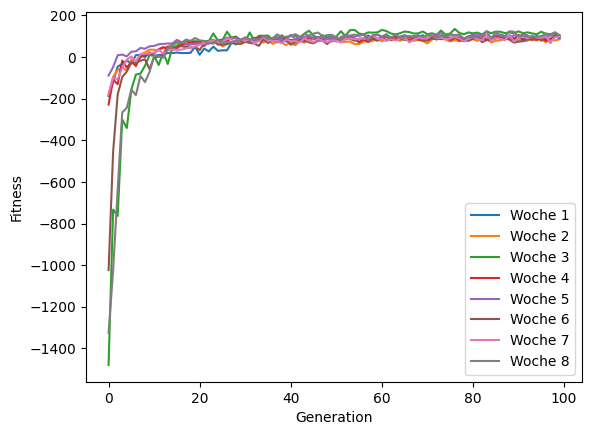

In [119]:
# Visualisierung: Beste Fitnesswerte je Woche über Generationen

for week_number in best_schedule_by_week.keys():
    plt.plot(range(len(best_scores_by_week[week_number])), best_scores_by_week[week_number], label=f'Woche {week_number}')
    
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend()
plt.show()

#### Erläuterung / Begründung zur Modellierung von Individuen
Die Prüfungspläne der einzelnen Wochen wurden als Individuen definiert und jeweils in wöchentliche Populationen dem evolutionären Optimierungsalgorithmus unterzogen.
Da das Evolutionary Computing nativ und ohne Framework implementiert wurde, war keine separate Modellierung eines Individuums erforderlich sondern die vorgegebene Struktur konnte direkt verwendet werden.

### Anzeige der besten Ergebnisse für alle Wochen nach Evolution

Ein Beispiel wie ausgewertet werden kann. Die Bewertung einer Verletzung der proportionalen Raumzuteilung ist mit -10 festgesetzt (nicht ändern).

In [120]:
def count_slots(schedule):
    slot_count = {}
    
    for day, slots in schedule.items():
        for slot, rooms in slots.items():
            for program in rooms:
                if program not in slot_count:
                    slot_count[program] = 0
                slot_count[program] += 1
    
    return slot_count

def calculate_slot_allocation(week_number, configuration):
    study_programs = configuration['exam_weeks'].get(f"Week {week_number}", [])
    total_courses = sum(configuration['study_programs'][program] for program in study_programs)
    
    # Berechne die proportionalen Slots
    slot_allocation = {}
    for program in study_programs:
        num_courses = configuration['study_programs'][program]
        slot_allocation[program] = round((num_courses / total_courses) * 40)
    return slot_allocation
    
def evaluate_schedule(schedule, configuration):
    # Bewertung basierend auf der Popularität der Slots und Tage
    slot_popularity = configuration['time_slots']
    day_popularity = configuration['days']
    
    score = 0
    for day, slots in schedule.items():
        day_score = day_popularity[day]['popularity']
        for slot, rooms in slots.items():
            slot_score = slot_popularity[slot]['popularity']
            # Addiere die Beliebtheitswerte jedes belegten Slots
            if all(rooms):  # Nur wenn beide Slots belegt sind
                score += (day_score + slot_score)
    
    return score

def calculate_differences_and_penalty(slot_counts, slot_allocations):
    differences = {}
    total_penalty = 0
    
    for program in slot_allocations:
        allocated_slots = slot_allocations.get(program, 0)
        counted_slots = slot_counts.get(program, 0)
        
        difference = counted_slots - allocated_slots
        differences[program] = difference
        
        # Berechne die Strafe basierend auf der Abweichung
        penalty = abs(difference) * -10
        total_penalty += penalty
    
    return differences, total_penalty

for week_number in range(start_week, end_week + 1):
    current_best = best_schedule_by_week[week_number]
    # print()
    print_schedule(current_best)
    # Zähle die Slots, die den Studiengängen zugewiesen wurden
    slot_counts = count_slots(current_best)
    print("Slot-Zuweisung pro Studiengang:", slot_counts)

    # Berechne die proportionalen Slot-Zuteilungen
    slot_allocations = calculate_slot_allocation(week_number, configuration)
    print("Proportionale Slot-Zuteilung pro Studiengang:", slot_allocations)

    # Bewertungsfunktion
    schedule_score = evaluate_schedule(current_best, configuration)
    print("Bewertung des Zeitplans:", schedule_score)

    # Berechnungen durchführen
    slot_counts = count_slots(current_best)
    slot_allocations = calculate_slot_allocation(week_number, configuration)

    # Abweichungen und Strafen berechnen
    differences, total_penalty = calculate_differences_and_penalty(slot_counts, slot_allocations)

    # Ausgabe
    print("Abweichungen pro Studiengang:", differences)
    print("Gesamtstrafen:", total_penalty)
    print("Gesamtbewertung:", total_penalty+schedule_score)


-----------------------------------------------------------------------------------------------------------------
Zeit / Tage         Monday             Tuesday            Wednesday            Thursday             Friday       
                R1        R2        R1        R2        R1        R2        R1        R2        R1        R2    
-----------------------------------------------------------------------------------------------------------------
  Slot A       MT        ET        MT        MT        ET        ET        ET        ES       WIW        ET    
  Slot B      INF       INF       INF        MB       WIW        ES       INF       WIW        MT       INF    
  Slot C      WIW        MB        ET        ET        MT        MB        ET        MT       INF        MB    
  Slot D      INF       WIW        ES       WIW        MT       INF        MB        ET        ES       WIW    
-------------------------------------------------------------------------------------------------

### Begründung zum Modell

<...Ihr Text...>

### 2. Test und Bewertung 
Beim Testen des modells fällt auf, dass je nach gewichtung der einzelnen terme in der fittenssfunktion andere ergebnisse entstehen.
Hierbei kann es auch vorkommen, dass einzelne regeln stark verletzt werden wienn sie relativ gesehen deutlich niedriger gewichtet sind als anderen.
der absolute wert des gewichts ist hierbei jedoch nicht unbedingt aussagekräftig, da die skalen der eintzelnen terme nicht immer glich sind.
je na gewünschtem ergebniss, und je nach dem welche der regelen einem wichtiger sind, muss man also nach einer geeigneten kombination an gewichten suchen.
die im code festgelegten gewichte liefern eun subjektiv gutes ergebnis, bei dem alle der regelen einigermaßen gut berücksichtigt werden.


In [ ]:
# Ihr Code



### Diskussion der Ergebnisse 

<...Ihr Text...>

## Aufgabenteil 2: Constraint Satisfaction Problems

Entwerfen Sie ein KI Modell auf Basis von Constraints und setzen Sie dieses als
Jupyter Notebook um. Wählen Sie geeignete Constraints.

In [ ]:
from ortools.sat.python import cp_model
  

### 1. Variablen bestimmen 

... und ihre Wertebereiche!

In [ ]:
from ortools.sat.python import cp_model

def create_variables(model, configuration, week=1):
    """
    Erstellt die Variablen für das CSP-Modell.
    
    Args:
        model: Das OR-Tools CP-Model
        configuration: Dictionary mit der Konfiguration für das Problem
        week: Die zu betrachtende Woche (Standard: 1)
        
    Returns:
        Dictionary mit den erstellten Variablen
    """
    # Daten aus der Konfiguration extrahieren
    days = list(configuration['days'].keys())
    rooms = ['A', 'B']
    slots = [1, 2, 3, 4]

    # Anzahl der Studiengänge
    num_study_programs = len(configuration['study_programs'])

    # Variablen erstellen
    variables = {}
    for day in days:
        for slot_idx in slots:
            for room in rooms:
                var_name = f"slot_{slot_idx}_room_{room}_{day}_week_{week}"
                # Der Wertebereich ist die Liste der möglichen Studiengänge
                variables[var_name] = model.NewIntVar(
                    0,
                    num_study_programs - 1,
                    var_name
                )

    return variables

### Begründung zur Wahl der Variablen

Da jeder Zeitslot einer Prüfungswoche von verschiedenen Studiengängen belegt werden kann, ist es sinnvoll, die Slots als Variablen zu modellieren. Der jeweilige Wertebereich dieser Variablen umfasst die Studiengänge, die in der entsprechenden Woche Prüfungen abhalten können.

### 2. Constraints bestimmen

Hier liegt sicher die Hauptaufgabe. Zur Umsetzung als CSP ist ein geeigneter Fairnessrahmen als Grenzwert anzugeben (und als Constraint umzusetzen)

In [ ]:
def add_fairness_constraint(model, variables, studiengaenge, fairness_toleranz=0.2):
    """
    Fügt den Fairness-Constraint zum Modell hinzu.
    
    Args:
        model: Das OR-Tools CP-Model
        variables: Dictionary mit den Variablen des Modells
        studiengaenge: Dictionary mit Studiengängen und ihrer Anzahl an Kursgruppen
        fairness_toleranz: Erlaubte Abweichung von der proportionalen Verteilung
    """
    # Gesamtzahl der Kursgruppen berechnen
    gesamt_kursgruppen = sum(studiengaenge.values())

    # Gesamtzahl der Slots berechnen
    gesamt_slots = len(variables)

    # Für jeden Studiengang die faire Anzahl an Slots berechnen
    for sg_name, kursgruppen in studiengaenge.items():
        # Studiengang-ID ermitteln (angenommen, dies ist ein Index von 0 bis len(studiengaenge)-1)
        sg = list(studiengaenge.keys()).index(sg_name)

        # Proportionale Anzahl an Slots berechnen
        faire_slots = (kursgruppen / gesamt_kursgruppen) * gesamt_slots

        # Toleranzbereich definieren
        min_slots = int(faire_slots * (1 - fairness_toleranz))
        max_slots = int(faire_slots * (1 + fairness_toleranz))

        # Zähle, wie viele Slots dem Studiengang zugewiesen wurden
        sg_slots_indicators = []

        for slot_var in variables:
            # Erstelle eine Binärvariable für diesen Slot und Studiengang
            is_sg_assigned = model.NewBoolVar(f"is_sg_{sg}_assigned_to_{slot_var}")

            # Diese Variable ist 1, wenn der Studiengang diesem Slot zugewiesen ist, sonst 0
            model.Add(variables[slot_var] == sg).OnlyEnforceIf(is_sg_assigned)
            model.Add(variables[slot_var] != sg).OnlyEnforceIf(is_sg_assigned.Not())

            sg_slots_indicators.append(is_sg_assigned)

        # Füge den Constraint hinzu, dass die Anzahl der zugewiesenen Slots
        # innerhalb des Toleranzbereichs liegt
        model.Add(sum(sg_slots_indicators) >= min_slots)
        model.Add(sum(sg_slots_indicators) <= max_slots)


def add_dominance_constraint(model, variables, configuration, week=1, max_slots_per_sg_per_day=3):
    """
    Fügt einen harten Constraint hinzu, der verhindert, dass ein Studiengang zu viele Slots
    an einem Tag belegt.
    """
    # Daten aus der Konfiguration extrahieren
    days = list(configuration['days'].keys())
    sg_names = list(configuration['study_programs'].keys())

    # Für jeden Tag und jeden Studiengang
    for day in days:
        for sg_idx, sg_name in enumerate(sg_names):
            # Zähle, wie viele Slots diesem Studiengang an diesem Tag zugewiesen wurden
            sg_slots_today = []

            for slot_idx in [1, 2, 3, 4]:
                for room in ['A', 'B']:
                    var_name = f"slot_{slot_idx}_room_{room}_{day}_week_{week}"
                    if var_name in variables:
                        is_assigned = model.NewBoolVar(f"{var_name}_is_{sg_name}")
                        model.Add(variables[var_name] == sg_idx).OnlyEnforceIf(is_assigned)
                        model.Add(variables[var_name] != sg_idx).OnlyEnforceIf(is_assigned.Not())
                        sg_slots_today.append(is_assigned)

            # Begrenze die Anzahl der Slots, die ein Studiengang an einem Tag belegen darf
            model.Add(sum(sg_slots_today) <= max_slots_per_sg_per_day)


def add_soft_constraints(model, variables, configuration, week=1):
    """
    Fügt die weichen Constraints als Teil der Zielfunktion hinzu.
    
    Args:
        model: Das OR-Tools CP-Model
        variables: Dictionary mit den Variablen des Modells
        configuration: Dictionary mit der Konfiguration für das Problem
        week: Die zu betrachtende Woche
        
    Returns:
        Liste der Terme für die Zielfunktion
    """
    # Daten aus der Konfiguration extrahieren
    studiengaenge = configuration['study_programs']
    days = list(configuration['days'].keys())
    sg_names = list(studiengaenge.keys())

    # Liste der Studiengänge mit mehreren Kursgruppen
    study_programs_with_more_than_one_course = [
        k for k, v in studiengaenge.items() if v > 1
    ]

    # Zielfunktionsterme
    objective_terms = []

    # 1. Weicher Constraint: Studiengänge mit mehreren Kursgruppen sollten
    # beide Räume gleichzeitig nutzen können
    parallel_weight = configuration.get('room_popularity', {}).get('parallel', 7)
    for day in days:
        for slot_idx in [1, 2, 3, 4]:
            # Für jeden Tag und Zeitslot
            var_name_a = f"slot_{slot_idx}_room_A_{day}_week_{week}"
            var_name_b = f"slot_{slot_idx}_room_B_{day}_week_{week}"

            # Für jeden Studiengang mit mehreren Kursgruppen
            for sg_name in study_programs_with_more_than_one_course:
                sg_idx = sg_names.index(sg_name)

                # Erstelle eine Binärvariable, die angibt, ob der Studiengang
                # beide Räume gleichzeitig nutzt
                uses_both_rooms = model.NewBoolVar(
                    f"sg_{sg_idx}_uses_both_rooms_{day}_{slot_idx}"
                )

                # Diese Variable ist 1, wenn der Studiengang beide Räume nutzt
                model.Add(variables[var_name_a] == sg_idx).OnlyEnforceIf(uses_both_rooms)
                model.Add(variables[var_name_b] == sg_idx).OnlyEnforceIf(uses_both_rooms)

                # Füge einen Bonus zur Zielfunktion hinzu basierend auf der Konfiguration
                objective_terms.append(uses_both_rooms * parallel_weight)

    # 2. Weicher Constraint: Zeitslot-Popularität berücksichtigen
    time_slots = ["Slot A", "Slot B", "Slot C", "Slot D"]
    for var_name, var in variables.items():
        # Extrahiere den Slot-Index aus dem Variablennamen
        parts = var_name.split('_')
        slot_idx = int(parts[1])

        # Entsprechenden Zeitslot und seine Popularität ermitteln
        time_slot = time_slots[slot_idx-1]
        slot_popularity = configuration['time_slots'][time_slot]['popularity']

        # Für jeden Studiengang eine Bewertung basierend auf dem Zeitslot hinzufügen
        for sg_idx in range(len(sg_names)):
            is_assigned = model.NewBoolVar(f"{var_name}_is_sg_{sg_idx}")
            model.Add(var == sg_idx).OnlyEnforceIf(is_assigned)

            # Füge einen Bonus basierend auf der Slot-Popularität hinzu
            objective_terms.append(is_assigned * slot_popularity)

    # 3. Weicher Constraint: Wochentag-Popularität berücksichtigen
    for var_name, var in variables.items():
        # Extrahiere den Tag aus dem Variablennamen
        parts = var_name.split('_')
        day_index = parts.index('week') - 1
        day = parts[day_index]

        # Popularität des Tages ermitteln
        day_popularity = configuration['days'][day]['popularity']

        # Für jeden Studiengang eine Bewertung basierend auf dem Tag hinzufügen
        for sg_idx in range(len(sg_names)):
            is_assigned = model.NewBoolVar(f"{var_name}_is_day_{sg_idx}")
            model.Add(var == sg_idx).OnlyEnforceIf(is_assigned)

            # Füge einen Bonus basierend auf der Tag-Popularität hinzu
            objective_terms.append(is_assigned * day_popularity)

    # 4. Weicher Constraint: Sequentielle Prüfungen
    sequential_weight = configuration.get('room_popularity', {}).get('sequential', 5)
    for day in days:
        for sg_idx in range(len(sg_names)):
            # Prüfe für aufeinanderfolgende Zeitslots
            for slot_idx in range(1, 4):  # Slots 1, 2, 3 (da wir den nachfolgenden betrachten)
                # Variablen für aktuelle und nächste Zeitslots
                current_slots = []
                next_slots = []

                for room in ['A', 'B']:
                    current_var_name = f"slot_{slot_idx}_room_{room}_{day}_week_{week}"
                    next_var_name = f"slot_{slot_idx+1}_room_{room}_{day}_week_{week}"

                    current_is_sg = model.NewBoolVar(f"{current_var_name}_is_sg_{sg_idx}")
                    next_is_sg = model.NewBoolVar(f"{next_var_name}_is_sg_{sg_idx}")

                    model.Add(variables[current_var_name] == sg_idx).OnlyEnforceIf(current_is_sg)
                    model.Add(variables[next_var_name] == sg_idx).OnlyEnforceIf(next_is_sg)

                    current_slots.append(current_is_sg)
                    next_slots.append(next_is_sg)

                # Für jede Kombination prüfen, ob aufeinanderfolgende Slots
                # vom gleichen Studiengang belegt werden
                for current in current_slots:
                    for next_slot in next_slots:
                        sequential = model.NewBoolVar(
                            f"sg_{sg_idx}_sequential_{day}_{slot_idx}"
                        )
                        model.AddBoolAnd([current, next_slot]).OnlyEnforceIf(sequential)

                        # Füge einen Bonus zur Zielfunktion hinzu basierend auf der Konfiguration
                        objective_terms.append(sequential * sequential_weight)

    # 5. Weicher Constraint: Vermeidung ungünstiger Abfolgen (spät/früh)
    for day_idx in range(len(days) - 1):
        day = days[day_idx]
        next_day = days[day_idx + 1]

        # Für jeden Studiengang
        for sg_idx in range(len(sg_names)):
            # Prüfe, ob der Studiengang einen späten Slot heute hat
            has_late_today = []
            for slot_idx in [3, 4]:  # Späte Slots
                for room in ['A', 'B']:
                    var_name = f"slot_{slot_idx}_room_{room}_{day}_week_{week}"
                    is_late = model.NewBoolVar(f"{var_name}_is_late_for_sg_{sg_idx}")
                    model.Add(variables[var_name] == sg_idx).OnlyEnforceIf(is_late)
                    has_late_today.append(is_late)

            # Prüfe, ob der Studiengang einen frühen Slot morgen hat
            has_early_tomorrow = []
            for slot_idx in [1, 2]:  # Frühe Slots
                for room in ['A', 'B']:
                    var_name = f"slot_{slot_idx}_room_{room}_{next_day}_week_{week}"
                    is_early = model.NewBoolVar(f"{var_name}_is_early_for_sg_{sg_idx}")
                    model.Add(variables[var_name] == sg_idx).OnlyEnforceIf(is_early)
                    has_early_tomorrow.append(is_early)

            # Füge eine Strafe für ungünstige Abfolgen hinzu
            for late in has_late_today:
                for early in has_early_tomorrow:
                    bad_sequence = model.NewBoolVar(
                        f"sg_{sg_idx}_bad_sequence_{day}_{next_day}"
                    )
                    model.AddBoolAnd([late, early]).OnlyEnforceIf(bad_sequence)

                    # Füge eine negative Gewichtung zur Zielfunktion hinzu
                    objective_terms.append(bad_sequence.Not() * 25)  # Hohe Gewichtung für diesen Constraint

    # 6. Weicher Constraint: Täglicher Slot für jeden Studiengang
    for day in days:
        for sg_idx in range(len(sg_names)):
            # Prüfe, ob der Studiengang an diesem Tag mindestens einen Slot hat
            has_slot_today = []

            for slot_idx in [1, 2, 3, 4]:
                for room in ['A', 'B']:
                    var_name = f"slot_{slot_idx}_room_{room}_{day}_week_{week}"
                    is_assigned = model.NewBoolVar(f"{var_name}_is_assigned_to_sg_{sg_idx}")
                    model.Add(variables[var_name] == sg_idx).OnlyEnforceIf(is_assigned)
                    has_slot_today.append(is_assigned)

            # Erstelle eine Variable, die angibt, ob der Studiengang
            # an diesem Tag mindestens einen Slot hat
            has_any_slot = model.NewBoolVar(f"sg_{sg_idx}_has_slot_{day}")
            model.AddBoolOr(has_slot_today).OnlyEnforceIf(has_any_slot)
            model.AddBoolAnd([var.Not() for var in has_slot_today]).OnlyEnforceIf(has_any_slot.Not())

            # Füge einen Bonus zur Zielfunktion hinzu
            objective_terms.append(has_any_slot * 15)

    return objective_terms


def solve_exam_scheduling_csp(configuration, week=1, time_limit=60):
    """
    Löst das Klausurslotverteilungsproblem mit OR-Tools
    
    Args:
        configuration: Dictionary mit der Konfiguration für das Problem
        week: Die zu betrachtende Woche (Standard: 1)
        time_limit: Zeitlimit in Sekunden (Standard: 60)
        
    Returns:
        Dictionary mit der Lösung oder None, wenn keine Lösung gefunden wurde
    """
    # Modell erstellen
    model = cp_model.CpModel()

    # Variablen erstellen
    variables = create_variables(model, configuration, week)

    # Constraints hinzufügen
    # Harter Constraint: Fairness
    add_fairness_constraint(model, variables, configuration['study_programs'])

    # Harter Constraint: Begrenze die Dominanz eines Studiengangs pro Tag
    add_dominance_constraint(model, variables, configuration, week, max_slots_per_sg_per_day=3)

    # Weiche Constraints als Teil der Zielfunktion
    objective_terms = add_soft_constraints(model, variables, configuration, week)

    # Zielfunktion maximieren
    model.Maximize(sum(objective_terms))

    # Lösung finden
    solver = cp_model.CpSolver()
    solver.parameters.max_time_in_seconds = time_limit
    status = solver.Solve(model)

    # Lösung auswerten
    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        # Lösung gefunden
        solution = {}
        for var_name, var in variables.items():
            sg_idx = solver.Value(var)
            sg_name = list(configuration['study_programs'].keys())[sg_idx]
            solution[var_name] = sg_name

        print(f"Lösung gefunden mit Status: {status}")
        print(f"Objektiver Wert: {solver.ObjectiveValue()}")

        return solution
    else:
        print(f"Keine Lösung gefunden. Status: {status}")
        return None


def display_solution(solution, configuration, week=1):
    """
    Zeigt die gefundene Lösung an.
    
    Args:
        solution: Dictionary mit der Lösung
        configuration: Dictionary mit der Konfiguration
        week: Die betrachtete Woche
    """
    if solution is None:
        print("Keine Lösung vorhanden.")
        return

    # Tage und Slots extrahieren
    days = list(configuration['days'].keys())
    slots = ["8:00-10:00", "10:30-12:30", "13:00-15:00", "15:30-17:30"]

    # Lösung anzeigen
    print(f"\nStundenplan für Woche {week}:")
    print("-" * 80)

    # Kopfzeile mit den Tagen
    header = "Zeitslot       | "
    for day in days:
        header += f"{day:^12} | "
    print(header)
    print("-" * 80)

    # Zeilen für jeden Zeitslot
    for slot_idx, slot_time in enumerate(slots, 1):
        row = f"{slot_time} | "

        for day in days:
            room_a_var = f"slot_{slot_idx}_room_A_{day}_week_{week}"
            room_b_var = f"slot_{slot_idx}_room_B_{day}_week_{week}"

            room_a = solution.get(room_a_var, "-")
            room_b = solution.get(room_b_var, "-")

            cell = f"A:{room_a}, B:{room_b}"
            row += f"{cell:^12} | "

        print(row)
    print("-" * 80)


# Hauptfunktion zum Ausführen des CSP-Modells
def run_exam_scheduling_csp(configuration):
    """
    Führt das CSP-Modell für die Klausurslotverteilung aus.
    
    Args:
        configuration: Dictionary mit der Konfiguration für das Problem
    """
    # Löse das Problem für eine Woche
    week = 1
    solution = solve_exam_scheduling_csp(configuration, week)

    # Zeige die Lösung an
    if solution:
        display_solution(solution, configuration, week)

    return solution


solution = run_exam_scheduling_csp(configuration)
print(solution)

### Begründungen 

<...Ihr Text...>

### 3. Test und Bewertung

Wie gut ist die Lösung? Prüfen Sie Ihre Konfiguration (u.a. abhängig von Constraint und Variablenwahl) und testen Sie geeignet. 

In [ ]:
# Ihr Code


### Diskussion der Ergebnisse 

<...Ihr Text...>

# Abschluss

Vergleich der beiden Verfahren. Ggf. ist hier noch Code zum Vergleich zu ergänzen, ansonsten weitgehend durch Text.

<...Ihr Text...>